# Importing libraries : 

In [ ]:
import tensorflow as tf 
from tensorflow import keras

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array 
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools

# Parameters :

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 3
batch_size = 32


In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip
!unzip -nq fruits-360.zip
train_path = "fruits-360/Training"
valid_path = "fruits-360/Validation"
# useful for getting the number of files : 
image_files= glob(train_path+"/*/*.jp*g")
valid_images_files= glob(valid_path+"/*/*.jp*g")
#useful for getting the number of classes : 
folders = glob(train_path+"/*")
print("There are ", len(folders)," classes.")

--2022-10-20 22:56:54--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M   255KB/s    in 12m 10s 

2022-10-20 23:09:05 (255 KB/s) - ‘fruits-360.zip’ saved [190820824/190820824]

There are  60  classes.


### Checking an image

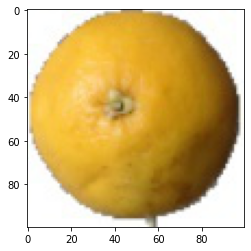

In [ ]:
plt.imshow(img_to_array(load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [ ]:
img_to_array(load_img(np.random.choice(image_files))).astype('uint8').shape

(100, 100, 3)

# Using VGG16

In [ ]:
# add preprocessing layer to the front of VGG16()
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg.layers

In [ ]:
# We don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
predictions=Dense(len(folders), activation ="softmax")(x)
model = Model(inputs= vgg.input, outputs=predictions) 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

### Data augmentation  

In [ ]:
gen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function =preprocess_input
)

In [ ]:
## Testing the generator : 
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

min: -104.818016 max: 151.061


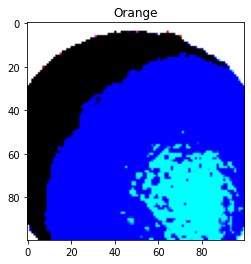

In [ ]:
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [ ]:
##Create generator 
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size)

valid_generator=gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [ ]:
r=model.fit(train_generator, 
            validation_data=valid_generator, 
            epochs= epochs,
            steps_per_epoch =len(image_files)//batch_size,
            validation_steps =len(valid_images_files)// batch_size
           )

Epoch 1/3
898/898 [==============================] - 148s 154ms/step - loss: 1.6528 - accuracy: 0.8828 - val_loss: 1.2756 - val_accuracy: 0.9207
Epoch 2/3
898/898 [==============================] - 125s 140ms/step - loss: 0.2913 - accuracy: 0.9732 - val_loss: 0.6344 - val_accuracy: 0.9571
Epoch 3/3
898/898 [==============================] - 125s 140ms/step - loss: 0.1819 - accuracy: 0.9840 - val_loss: 0.8193 - val_accuracy: 0.9543


In [ ]:
def get_confusion_matrix(data_path, N): 
    #we need to see the data in the same order 
    #for both predictions and targets 
    print("generating confusion matrix " , N)
    predictions=[]
    targets=[]
    i = 0 
    n_images=0
    for x, y in gen.flow_from_directory(
        data_path, 
        target_size= IMAGE_SIZE,
        shuffle = False, 
        batch_size= batch_size*2
    ): 
        i+=1 
        n_images+=len(y)
        if i % 50== 0 : 
            print(f'{n_images} images processed')

        p =model.predict(x)
        p= np.argmax(p, axis=1)
        y=np.argmax(y, axis=1)  
        predictions = np.concatenate((predictions, p))
        targets= np.concatenate((targets,y))
        if len(targets) >= N : 
            break
    
    cm = confusion_matrix(targets , predictions)
    return cm 

cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

valid_cm=get_confusion_matrix(valid_path, len(valid_images_files))
print(valid_cm)

generating confusion matrix  28736
Found 28736 images belonging to 60 classes.
2/2 [==============================] - 0s 41ms/step
3200 images processed
2/2 [==============================] - 0s 41ms/step
6400 images processed
2/2 [==============================] - 0s 41ms/step
9600 images processed
2/2 [==============================] - 0s 43ms/step
12800 images processed
2/2 [==============================] - 0s 41ms/step
16000 images processed
2/2 [==============================] - 0s 43ms/step
19200 images processed
2/2 [==============================] - 0s 41ms/step
22400 images processed
2/2 [==============================] - 0s 41ms/step
25600 images processed
2/2 [==============================] - 0s 44ms/step
[[363   0   0 ...   0   0   0]
 [  0 484   7 ...   0   0   0]
 [  0   0 489 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 486   0]
 [  0   0   0 ...   0   0 490]]
generating confusion matrix  9673
Found 9673 images belonging to 60 classes.
2/2

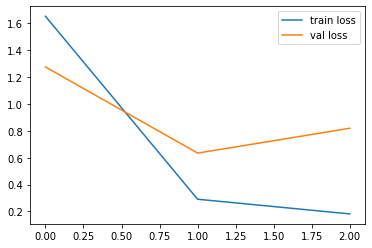

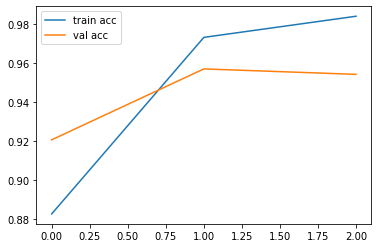

In [ ]:
#Plot overfitting : 
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title="confusion matrix", cmap = plt.cm.Blues):
    """This function prints and plots the confusion matrix. Normalization can be applied by setting "normalize=True".
    """
    if normalize: 
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else : 
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation="nearest", cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks,classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2
    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j]> thresh else "black"
                 )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted_label")

    plt.show()

Confusion matrix, without normalization
[[363   0   0 ...   0   0   0]
 [  0 484   7 ...   0   0   0]
 [  0   0 489 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 486   0]
 [  0   0   0 ...   0   0 490]]


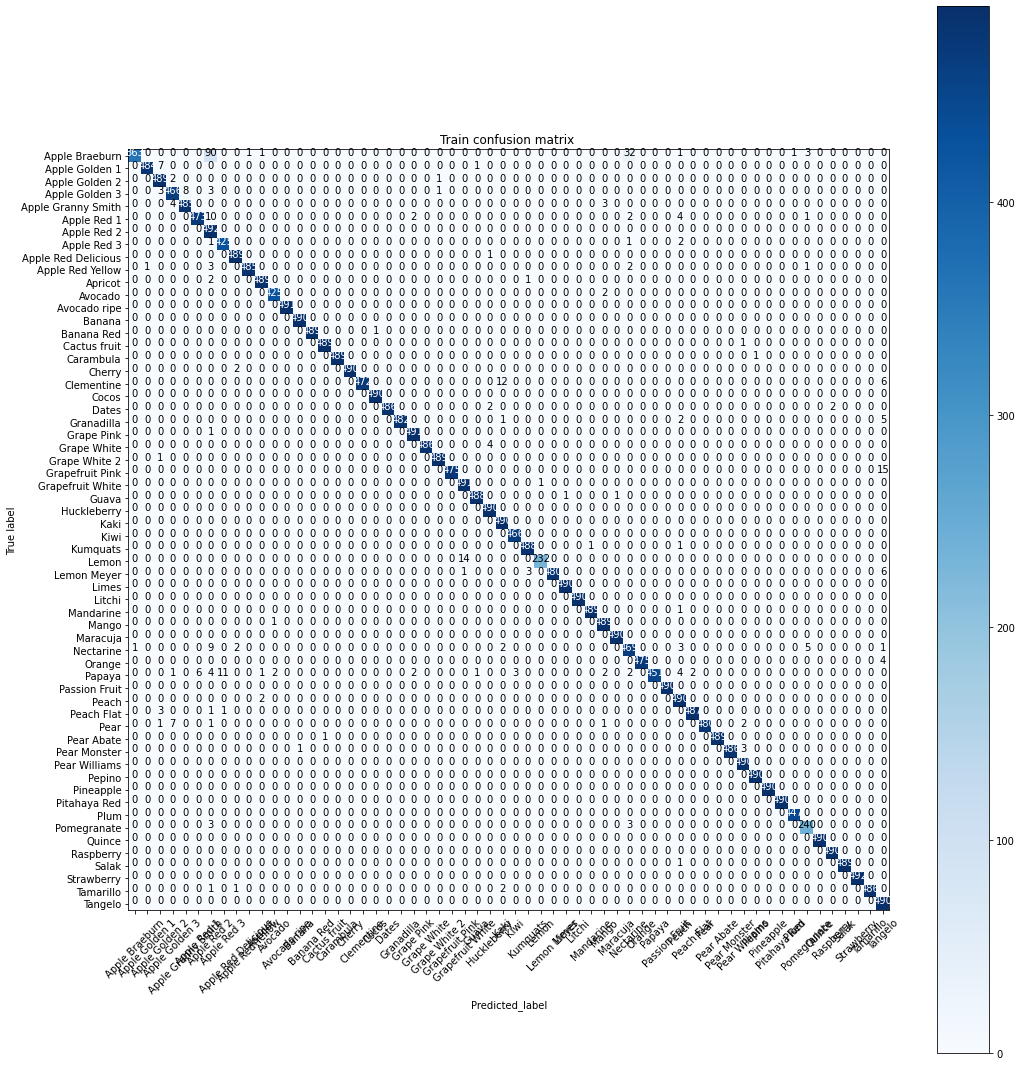

In [ ]:
plot_confusion_matrix(cm, labels, title="Train confusion matrix ")

Confusion matrix, without normalization
[[ 92   0   0 ...   0   0   0]
 [  0 161   1 ...   0   0   0]
 [  0   0 161 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 165   0]
 [  0   0   0 ...   0   0 166]]


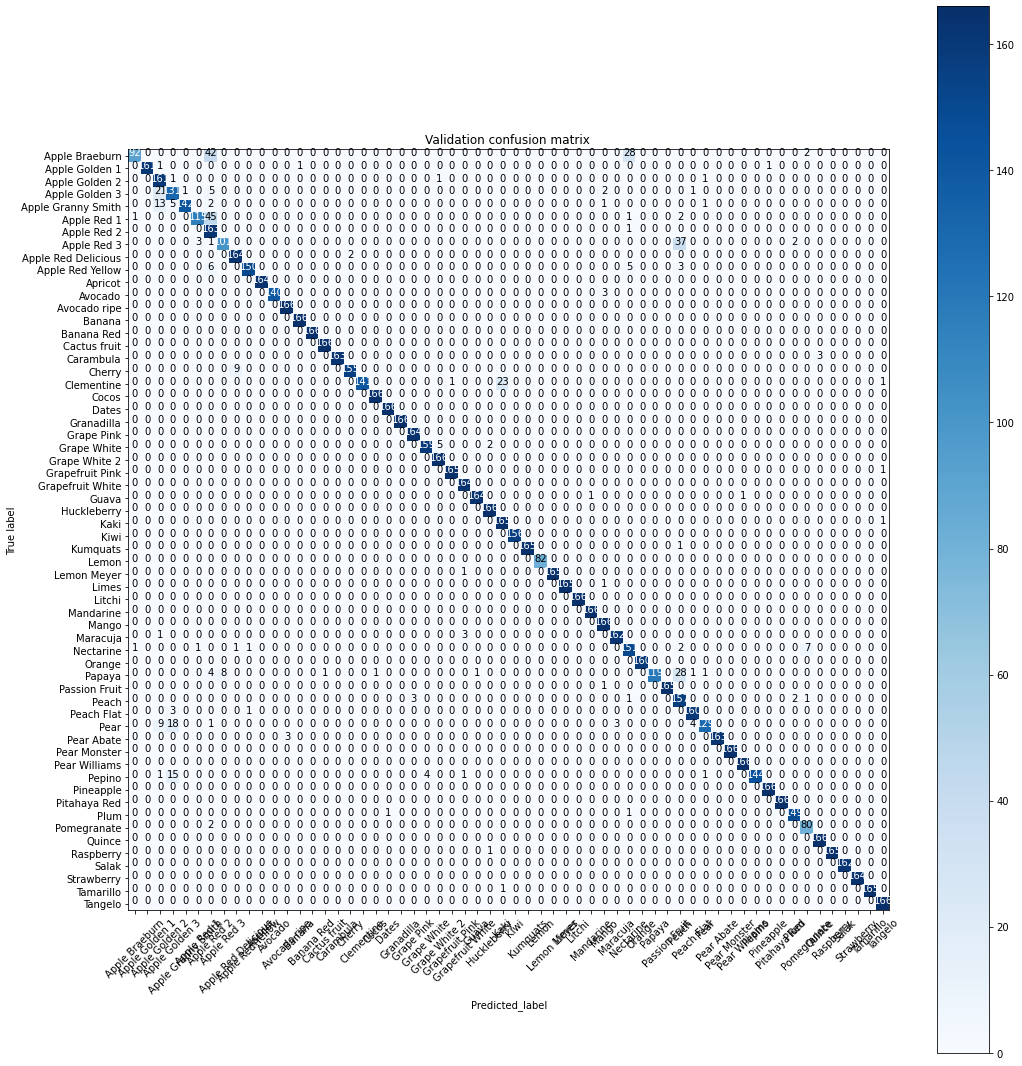

In [ ]:
plot_confusion_matrix(valid_cm, labels, title="Validation confusion matrix ")